In [2]:
import psycopg2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]

from pprint import pprint

try:
  con
except NameError:
  con = psycopg2.connect(user="postgres", dbname="comparisondb", password="coap")
  con.set_session(readonly=True, autocommit=False)

In [3]:
exp_data_sql = """
SELECT 
    ex.exp_id,
    ex.num_trials, 
    d.dnid,
    n.*
FROM 
	experiment ex
  JOIN deployed_node d ON d.exp_id = ex.exp_id
  JOIN node n ON d.node_id = n.node_id
  JOIN event e ON e.observer_id = d.dnid
GROUP BY
	ex.exp_id,
    n.node_id,
    d.dnid
ORDER BY
  ex.attacker_rate,
  ex.proxy_connections
;
"""
lay_of_the_land = pd.read_sql_query(exp_data_sql, con)
con.commit()
print("\n".join(lay_of_the_land.exp_id.unique().tolist()))
lay_of_the_land

1client_0attacker_infinite_requests_many_trials
1client_1attacker_infinite_requests_many_trials
2client_0attacker_infinite_requests_many_trials
2client_1attacker_infinite_requests_many_trials
3client_1attacker_infinite_requests
3client_1attacker_infinite_requests_many_trials
4client_0attacker_infinite_requests_many_trials
4client_1attacker_infinite_requests_many_trials
5client_0attacker_infinite_requests_many_trials
5client_1attacker_infinite_requests_many_trials
proper_3client_no_attacker_infinite_requests


,exp_id,num_trials,dnid,node_id,node_name,hardware_type,operating_system
0,1client_0attacker_infinite_requests_many_trials,5,26,1,originserver,pc2133,ubuntu1804-std
1,1client_0attacker_infinite_requests_many_trials,5,27,4,proxy,microcloud,ubuntu1804-std
2,1client_0attacker_infinite_requests_many_trials,5,23,9,client1,pc2133,ubuntu1804-std
3,1client_1attacker_infinite_requests_many_trials,5,40,1,originserver,pc2133,ubuntu1804-std
4,1client_1attacker_infinite_requests_many_trials,5,42,2,receiver,pc3000,ubuntu1804-std
...,...,...,...,...,...,...,...
60,proper_3client_no_attacker_infinite_requests,3,5,1,originserver,pc2133,ubuntu1804-std
61,proper_3client_no_attacker_infinite_requests,3,6,4,proxy,microcloud,ubuntu1804-std
62,proper_3client_no_attacker_infinite_requests,3,2,5,client1,pc3000,ubuntu1804-std
63,proper_3client_no_attacker_infinite_requests,3,3,6,client2,pc3000,ubuntu1804-std


In [4]:
exp_id = "1client_1attacker_infinite_requests_many_trials"

node_map_node_id = dict()
node_map_dnid = dict()

df = lay_of_the_land
records = df[(df["exp_id"] == exp_id)][["node_name", "dnid", "node_id"]].to_records(index=False)
client_node_ids = set()
client_dnids = set()
proxy_node_id = None
for node_name, dnid, node_id in records:
    node_map_node_id[node_name] = node_id
    node_map_dnid[node_name] = dnid
    if node_name.startswith("client"):
        client_node_ids.add(node_id)
        client_dnids.add(dnid)
    elif node_name == 'proxy':
        proxy_node_id = node_id
    
pprint(node_map_node_id)
pprint(node_map_dnid)
pprint(client_node_ids)
pprint(client_dnids)
pprint(proxy_node_id)

{'attacker': 8, 'client1': 9, 'originserver': 1, 'proxy': 4, 'receiver': 2}
{'attacker': 36, 'client1': 37, 'originserver': 40, 'proxy': 41, 'receiver': 42}
{9}
{37}
4


In [5]:
summary_sql = f"""
SELECT 
	n.node_name AS observer,
	e.trial,
	COUNT (DISTINCT e.message_marker) AS unique_messages,
	COUNT (e.message_marker) AS total_messages,
	MIN(e.observe_timestamp) min_timestamp_sec,
	MAX(e.observe_timestamp) max_timestamp_sec,
	MAX(e.observe_timestamp) - MIN(e.observe_timestamp) active_time_sec
FROM 
	deployed_node d 
	JOIN node n ON n.node_id = d.node_id
	JOIN "event" e ON e.observer_id = d.dnid
WHERE 
	d.exp_id = '{exp_id}'
GROUP BY
	n.node_name,
	e.trial
"""

sdf = pd.read_sql_query(summary_sql, con)
con.commit()
sdf

,observer,trial,unique_messages,total_messages,min_timestamp_sec,max_timestamp_sec,active_time_sec
0,attacker,1,286064,286064,1.637184e+09,1.637184e+09,19.776925
1,attacker,2,281064,281064,1.637184e+09,1.637184e+09,19.859325
2,attacker,3,276551,276551,1.637185e+09,1.637185e+09,19.858019
3,attacker,4,286677,286677,1.637185e+09,1.637185e+09,19.858653
4,attacker,5,286001,286001,1.637185e+09,1.637185e+09,19.858796
5,client1,1,18947,37899,1.637184e+09,1.637184e+09,98.625328
6,client1,2,20766,41535,1.637184e+09,1.637185e+09,98.624766
7,client1,3,20328,40660,1.637185e+09,1.637185e+09,98.650390
8,client1,4,21199,42400,1.637185e+09,1.637185e+09,98.641059
9,client1,5,20213,40429,1.637185e+09,1.637185e+09,98.655944


In [6]:
client_messages_sql = f"""
SELECT
    e.observe_timestamp,
    e.message_marker,
    e.trial,
	m.src_id,
	m.dst_id,
    m.size_bytes
FROM
	event e
	JOIN message m ON e.message_id = m.message_id
WHERE
	e.observer_id IN ({','.join(map(str, client_dnids))})
ORDER BY
    e.observe_timestamp
;
"""

df = pd.read_sql_query(client_messages_sql, con)
con.commit()

# Negate timestamp of client src message to measure RTT
df["observe_timestamp"] = df.where(df["dst_id"].isin(client_node_ids), df["observe_timestamp"] * -1, axis=0)

rtts_df = df.groupby(by=["trial", "message_marker"]).agg(\
                                              rtt_sec=("observe_timestamp", "sum"), 
                                              timestamp=("observe_timestamp", "max"),
                                              src_id=("src_id", "max"),
                                              max_size_bytes=("size_bytes", "max")).reset_index()
rtts_df = rtts_df[rtts_df["rtt_sec"] > 0]
rtts_df["rtt_ms"] = rtts_df["rtt_sec"] * 1e3

rps_records = []

for t in rtts_df["trial"].unique():
    print(f"Trial {t}")
    trial_df = rtts_df[rtts_df["trial"] == t]
    for client_number, src_id in enumerate(trial_df["src_id"].unique(), start=1):
        print(f"-- Client {client_number}")
        client_trial_df = trial_df[trial_df["src_id"] == src_id]
        client_trial_df["count"] = np.arange(1, len(client_trial_df) + 1)
        print(client_trial_df.describe())
        average_rps = client_trial_df["count"].max() / (client_trial_df["timestamp"].max() - client_trial_df["timestamp"].min())
        print(f"\naverage_rps={average_rps}")
        print()
        
        rps_records.append({
            "trial": t, 
            "src_id": src_id,
            "client_number": client_number,
            "average_rps": average_rps,
        })

# Add average rps per client per trial to the rtts df
rps_df = pd.DataFrame.from_records(rps_records)
rtts_df = rtts_df.merge(rps_df[["trial", "src_id", "average_rps"]], on=["trial", "src_id"], how="left")
        
rtts_df

Trial 1
-- Client 1
         trial  message_marker       rtt_sec     timestamp   src_id  \
count  18940.0    18940.000000  18940.000000  1.894000e+04  18940.0   
mean       1.0   222516.849736      0.004192  1.637184e+09      9.0   
std        0.0   126418.419076      0.004948  2.921063e+01      0.0   
min        1.0        1.000000      0.003028  1.637184e+09      9.0   
25%        1.0   176841.000000      0.003818  1.637184e+09      9.0   
50%        1.0   295540.500000      0.004027  1.637184e+09      9.0   
75%        1.0   300275.250000      0.004079  1.637184e+09      9.0   
max        1.0   305010.000000      0.257349  1.637184e+09      9.0   

       max_size_bytes        rtt_ms         count  
count    18940.000000  18940.000000  18940.000000  
mean       109.413939      4.191941   9470.500000  
std          0.609806      4.948336   5467.651385  
min        106.000000      3.027916      1.000000  
25%        109.000000      3.818035   4735.750000  
50%        109.000000      4

,trial,message_marker,rtt_sec,timestamp,src_id,max_size_bytes,rtt_ms,average_rps
0,1,1,0.102465,1.637184e+09,9,106,102.464914,192.239974
1,1,2,0.006916,1.637184e+09,9,106,6.916046,192.239974
2,1,3,0.006402,1.637184e+09,9,106,6.401777,192.239974
3,1,4,0.006278,1.637184e+09,9,106,6.278276,192.239974
4,1,5,0.005923,1.637184e+09,9,106,5.923033,192.239974
...,...,...,...,...,...,...,...,...
101421,5,306209,0.004090,1.637185e+09,9,110,4.090071,205.028186
101422,5,306210,0.004089,1.637185e+09,9,110,4.088879,205.028186
101423,5,306211,0.004087,1.637185e+09,9,110,4.086971,205.028186
101424,5,306212,0.004107,1.637185e+09,9,110,4.106998,205.028186


In [7]:
rtts_df["rtt_ms"].describe()

count    101426.000000
mean          4.082092
std           4.671011
min           3.010035
25%           3.814936
50%           3.973007
75%           4.079103
max         844.040871
Name: rtt_ms, dtype: float64

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


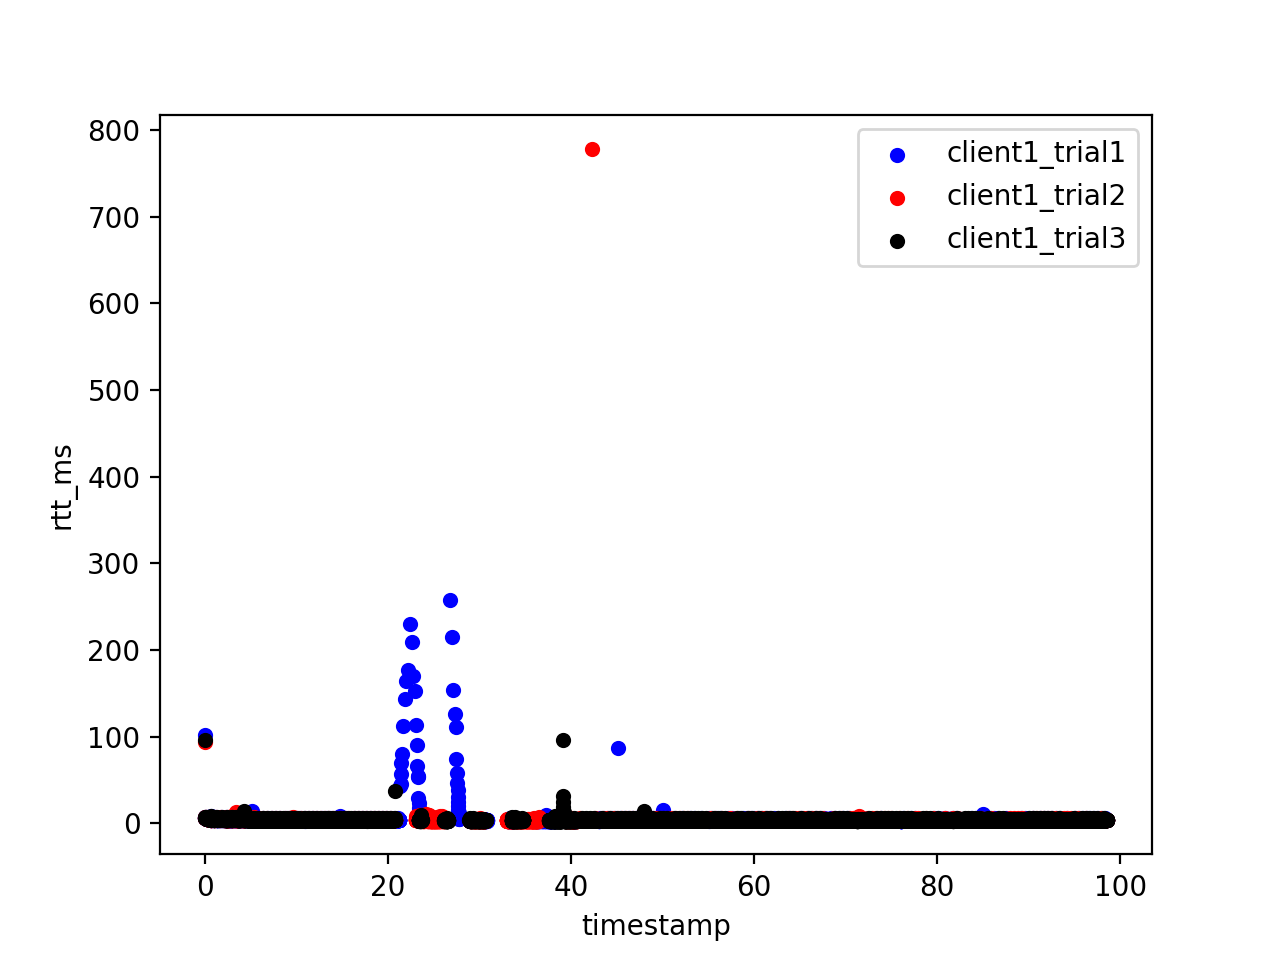

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [9]:
%matplotlib notebook

ignore_clients = {}
ignore_trials = {4,5}

ax = None
color_map = {(1,0): "orange", (1,1): "blue", (1,2): "red", (1,3): "black",
             (2,0): "skyblue", (2,1): "brown", (2,2): "gold", (2,3): "maroon",
             (3,0): "silver", (3,1): "green", (3,2): "purple", (3,3): "pink"}
for t in rtts_df["trial"].unique():
    if t in ignore_trials:
        continue
    trial_df = rtts_df[rtts_df["trial"] == t]
    min_timestamp = trial_df["timestamp"].min()
    trial_df["timestamp"] -= min_timestamp
    for client_number, src_id in enumerate(trial_df["src_id"].unique(), start=1):
        if client_number in ignore_clients:
            continue
        client_trial_df = trial_df[trial_df["src_id"] == src_id]
        label = f"client{client_number}_trial{t}"
        if ax:
            client_trial_df.plot(kind="scatter", x="timestamp", y="rtt_ms", label=label, ax=ax, color=color_map[(client_number, t)])
        else:
            ax = client_trial_df.plot(kind="scatter", x="timestamp", y="rtt_ms", label=label, color=color_map[(client_number, t)])
plt.show()

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

<IPython.core.display.Javascript object>


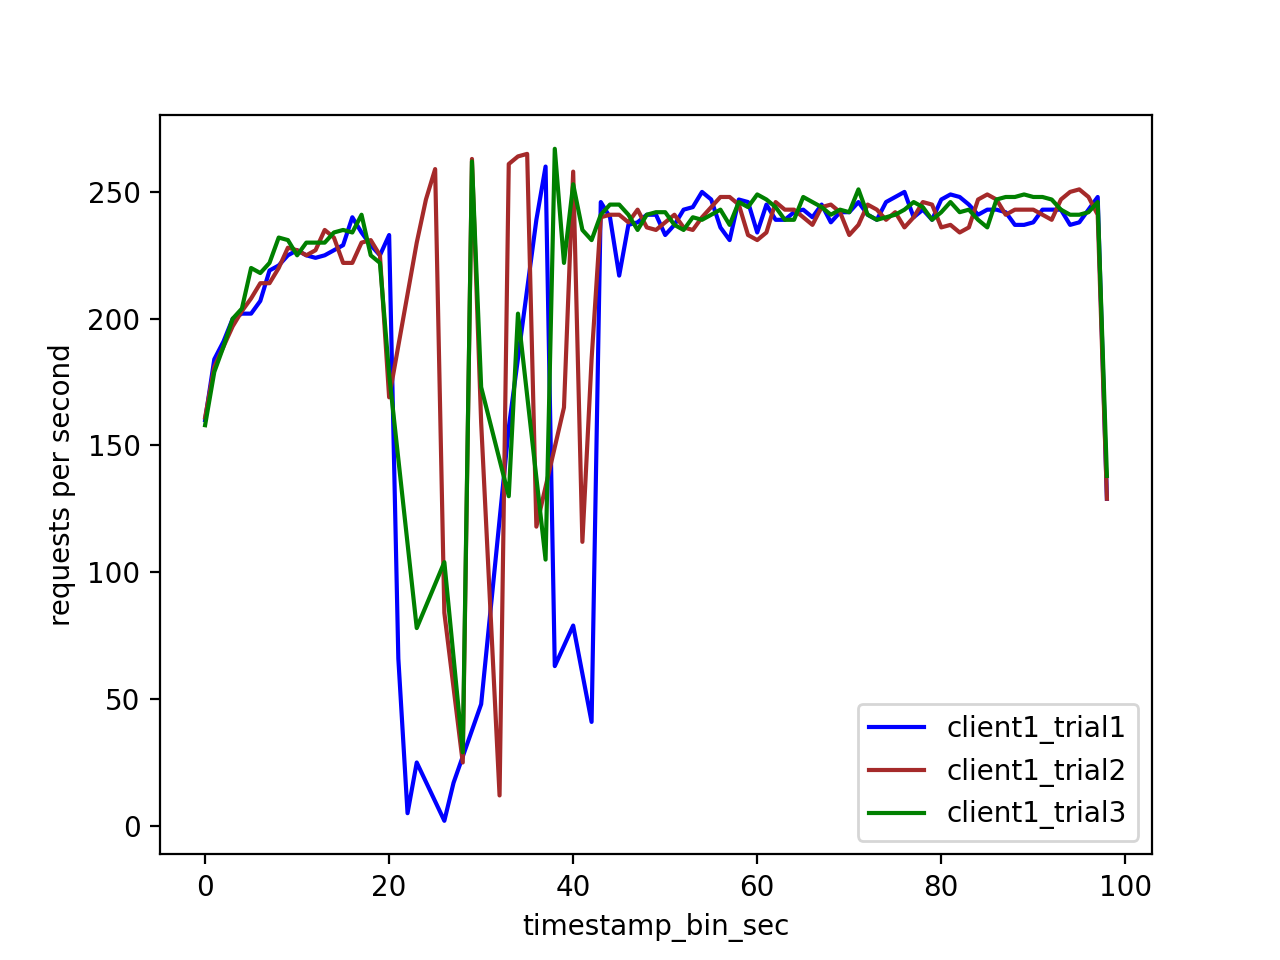

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

,timestamp_bin_sec,src_id,packets_per_second,bytes_per_second
0,0.0,9,158,16956
1,1.0,9,179,19332
2,2.0,9,189,20412
3,3.0,9,200,21600
4,4.0,9,204,22032
...,...,...,...,...
85,94.0,9,241,26510
86,95.0,9,241,26510
87,96.0,9,242,26620
88,97.0,9,246,27060


In [10]:
trial_df["timestamp_bin_sec"] = np.floor(trial_df["timestamp"])

ignore_clients = {}
ignore_trials = {4, 5}

ax = None
for t in rtts_df["trial"].unique():
    if t in ignore_trials:
        continue
    trial_df = rtts_df[rtts_df["trial"] == t]
    min_timestamp = trial_df["timestamp"].min()
    trial_df["timestamp"] -= min_timestamp
    trial_df["timestamp_bin_sec"] = np.floor(trial_df["timestamp"])
    time_stats_df = trial_df.groupby(by=["timestamp_bin_sec", "src_id"]).agg(\
                                             packets_per_second=("max_size_bytes", "count"),
                                             bytes_per_second=("max_size_bytes", "sum")).reset_index()
    
    for client_number, src_id in enumerate(trial_df["src_id"].unique(), start=1):
        if client_number in ignore_clients:
            continue
        client_trial_df = time_stats_df[time_stats_df["src_id"] == src_id]
        label = f"client{client_number}_trial{t}"
        color = color_map[(t, client_number)]
        ax = client_trial_df.plot(kind="line", x="timestamp_bin_sec", y="packets_per_second", ax=ax, color=color, label=label)

ax.set_ylabel("requests per second")
plt.show()

time_stats_df

<IPython.core.display.Javascript object>


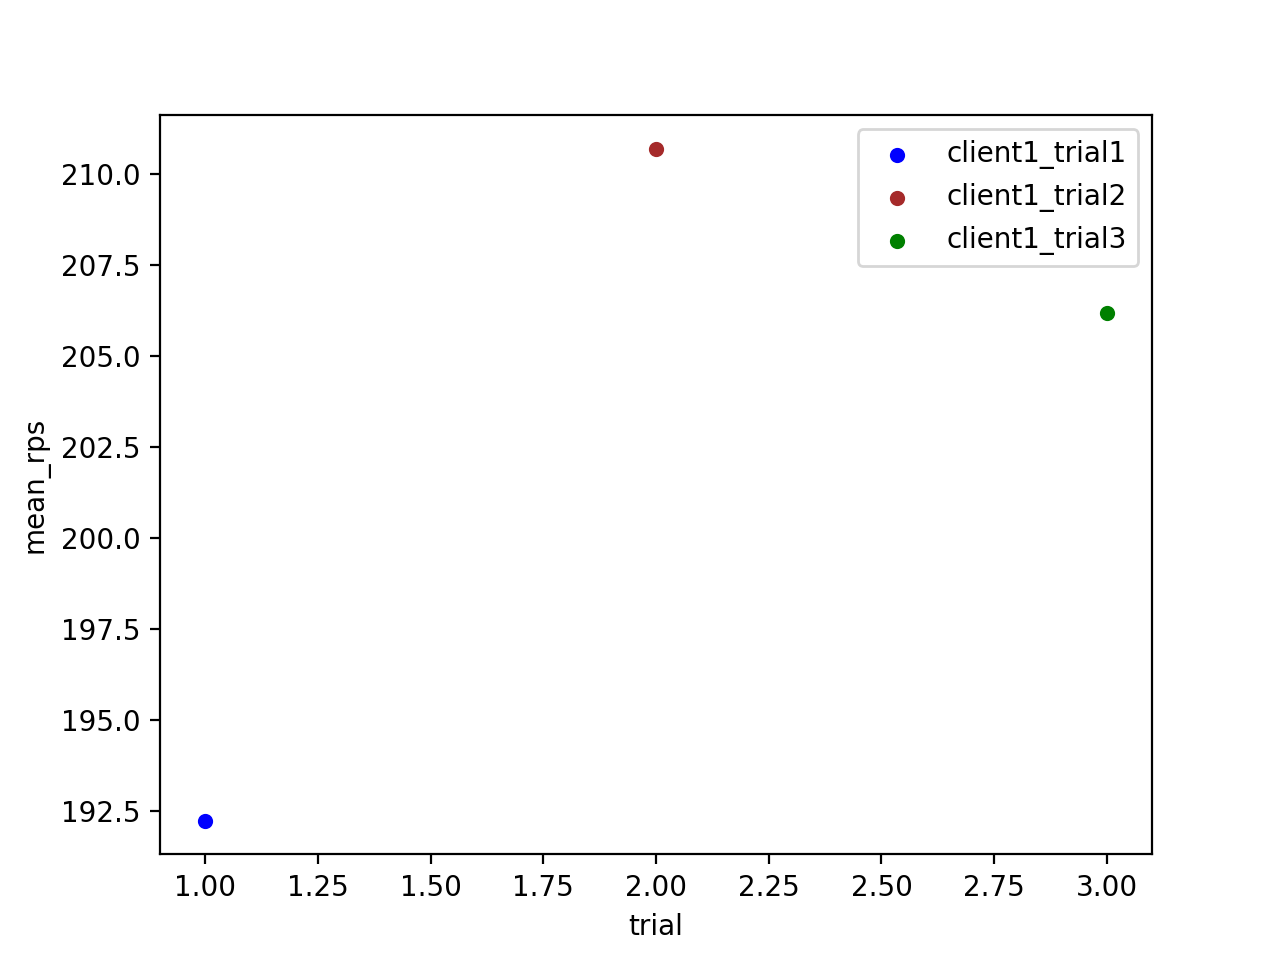

KeyError: (4, 1)

In [11]:
gdf = rtts_df.groupby(by=["src_id", "trial"]).agg(mean_rps=("average_rps", "mean")).reset_index()

ax = None
for t in gdf["trial"].unique():
    tdf = gdf[gdf["trial"] == t]
    for client_number, src_id in enumerate(tdf["src_id"].unique(), start=1):
        cdf = tdf[tdf["src_id"] == src_id]
        cdf["client_number"] = client_number
        ax = cdf.plot(kind="scatter", x="trial", y="mean_rps", ax=ax, label=f"client{client_number}_trial{t}", color=color_map[(t, client_number)])
        
print(gdf.groupby(by=["trial"]).mean().reset_index()[["trial", "mean_rps"]])
        
plt.show()

gdf

In [12]:
# Dataframe of attacker message RTT from attacker to receiver

attacker_messages_sql = f"""
WITH negate_attacker_timestamp AS (
SELECT
    e.trial,
	e.message_marker,
	e.observer_id,
	CASE WHEN e.observer_id={node_map_dnid['attacker']} THEN -1 * e.observe_timestamp
		 ELSE e.observe_timestamp
	END AS timestamp
FROM
	event e
	JOIN message m ON e.message_id = m.message_id
    JOIN node ndst ON ndst.node_id = m.dst_id
WHERE
	e.observer_id IN ({node_map_dnid['attacker']}, {node_map_dnid['receiver']})
)

SELECT 
	trial,
	message_marker,
	COUNT(timestamp) AS num_timestamps_should_be_2,
	MAX(timestamp) AS timestamp,
	SUM(timestamp) * 1e3 AS rtt_ms
FROM 
	negate_attacker_timestamp
GROUP BY
	trial,
	message_marker
"""

adf = pd.read_sql_query(attacker_messages_sql, con)
con.commit()
adf

adf["timestamp"] = abs(adf["timestamp"])
adf = adf[adf["rtt_ms"] > 0]
adf

,trial,message_marker,num_timestamps_should_be_2,timestamp,rtt_ms
0,1,4588,2,1.637184e+09,37.926912
1,1,4589,2,1.637184e+09,37.876844
2,1,4590,2,1.637184e+09,0.766039
3,1,4591,2,1.637184e+09,40.568829
4,1,4592,2,1.637184e+09,37.615061
...,...,...,...,...,...
1416352,5,292505,2,1.637185e+09,627.455950
1416353,5,292506,2,1.637185e+09,627.877951
1416354,5,292507,2,1.637185e+09,627.815723
1416355,5,292508,2,1.637185e+09,627.492905


In [17]:
attacker_df = adf
attacker_df["rtt_ms"].describe()

count    233884.000000
mean        117.180611
std         132.596579
min           0.000954
25%          18.815756
50%          93.006611
75%         158.142805
max         993.741989
Name: rtt_ms, dtype: float64

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


<IPython.core.display.Javascript object>


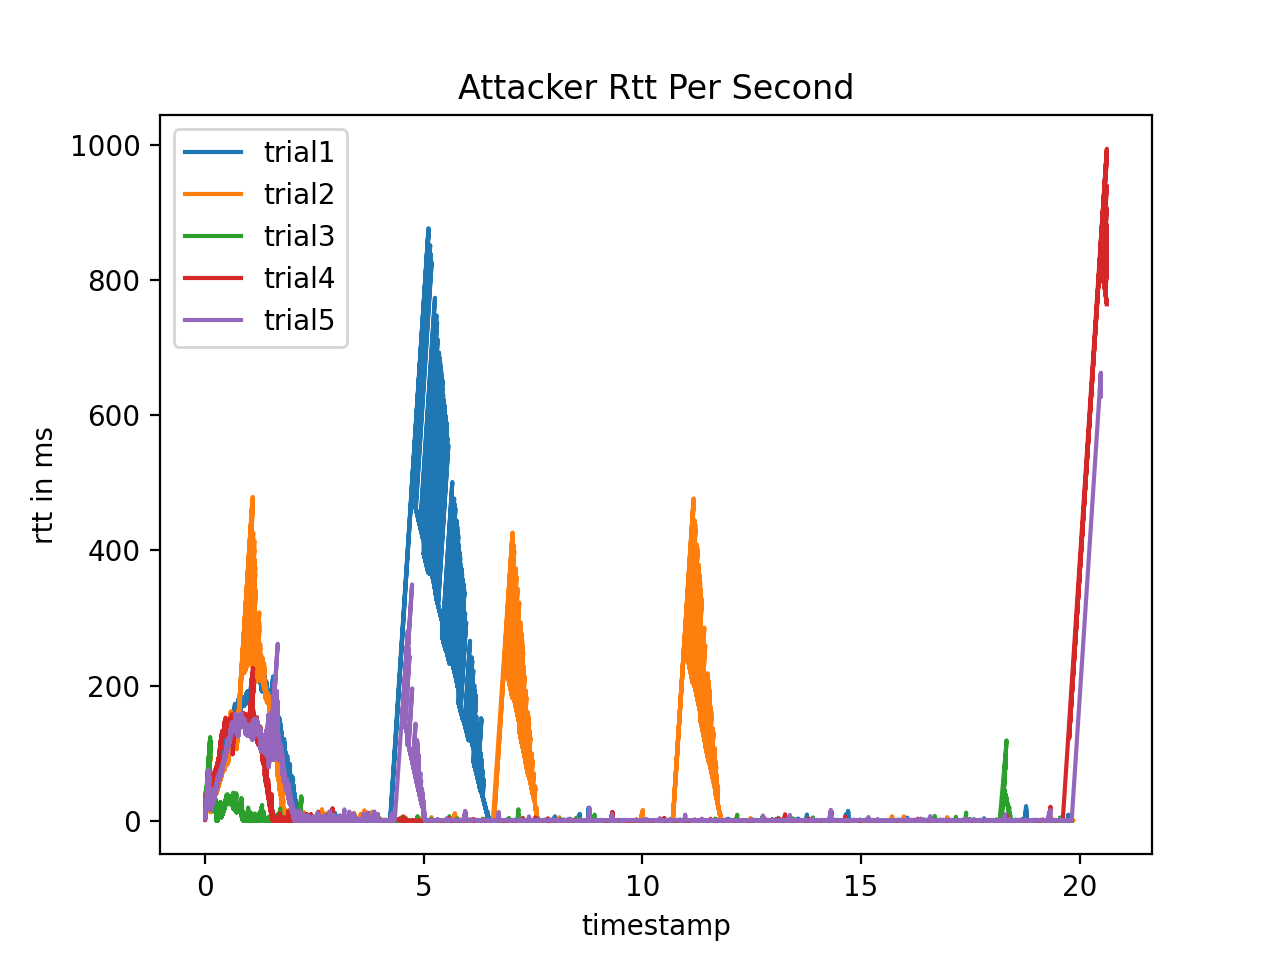

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

,trial,message_marker,num_timestamps_should_be_2,timestamp,rtt_ms
1130356,5,4425,2,0.001488,4.119873
1130357,5,4426,2,0.000756,3.289700
1130358,5,4428,2,0.000000,2.459049
1130359,5,4429,2,0.055263,57.648897
1130360,5,4430,2,0.000740,3.049135
...,...,...,...,...,...
1416352,5,292505,2,20.483338,627.455950
1416353,5,292506,2,20.483832,627.877951
1416354,5,292507,2,20.483839,627.815723
1416355,5,292508,2,20.483586,627.492905


In [14]:
ax = None
for t in adf["trial"].unique():
    trial_df = adf[adf["trial"] == t]
    min_timestamp = trial_df["timestamp"].min()
    trial_df["timestamp"] -= min_timestamp
    label = f"trial{t}"
    ax = trial_df.plot(kind="line", x="timestamp", y="rtt_ms", ax=ax, label=label)
    
ax.set_ylabel("rtt in ms")
ax.set_title("Attacker Rtt Per Second")
plt.show()

trial_df

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<IPython.core.display.Javascript object>


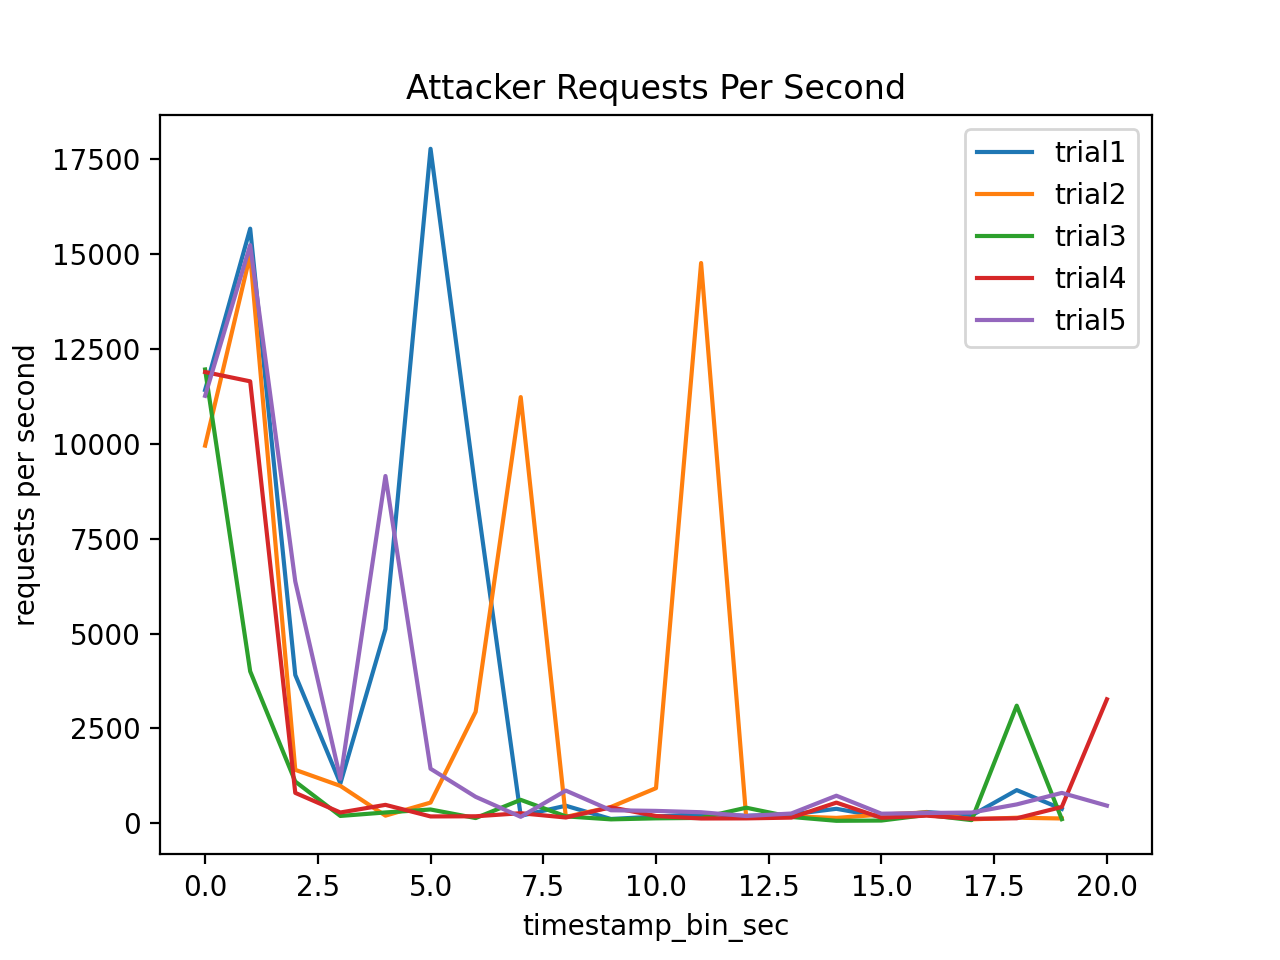

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

,timestamp_bin_sec,packets_per_second
0,0.0,11265
1,1.0,15237
2,2.0,6374
3,3.0,1174
4,4.0,9152
5,5.0,1438
6,6.0,698
7,7.0,171
8,8.0,862
9,9.0,344


In [15]:
ax = None
for t in adf["trial"].unique():
    trial_df = adf[adf["trial"] == t]
    min_timestamp = trial_df["timestamp"].min()
    trial_df["timestamp"] -= min_timestamp
    trial_df["timestamp_bin_sec"] = np.floor(trial_df["timestamp"])
    time_stats_df = trial_df.groupby(by=["timestamp_bin_sec"]).agg(\
                                         packets_per_second=("message_marker", "count")).reset_index()

    
    label = f"trial{t}"
    ax = time_stats_df.plot(kind="line", x="timestamp_bin_sec", y="packets_per_second", ax=ax, label=label)
    
ax.set_ylabel("requests per second")
ax.set_title("Attacker Requests Per Second")
plt.show()

time_stats_df